In [1]:
import glob
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np
import pandas as pd
import qiime2 as q2
import time
from biom import Table
from skbio.stats.composition import closure
from biom import load_table
from gemelli.rpca import rpca, joint_rpca, feature_correlation_table
from gemelli.rpca import rpca_table_processing
from sklearn.model_selection import train_test_split
from skbio.stats.composition import clr

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#turn off warnings
import warnings
warnings.filterwarnings("ignore")

## Data pre-processing

Only need to run these blocks once

In [2]:
data_path = '/Users/bec5786/Desktop/Shenhav Lab/Joint-RPCA/Case studies/iHMP/Data/'
data_path_ihmp = '{}ihmp_data/'.format(data_path)

In [3]:
# import and match the data the same as in ../../simulations-benchmarking/3.0-ihmp-benchmarks.ipynb
# we will also save each table with all the data for that table
# for exploration non-jointly based on the joint samples
tables = {omics_.split('/')[-1].split('.')[0]:rpca_table_processing(load_table(omics_),
                                                                    min_sample_count=0,
                                                                    min_feature_count=0,
                                                                    min_feature_frequency=0)
          for omics_ in glob.glob('{}*.biom'.format(data_path_ihmp))
          if not any ('_' + str(d_) in omics_ for d_ in [10, 8, 6, 4, 2, 1])}
metadata = pd.read_csv('{}sample-metadata.txt'.format(data_path_ihmp), sep='\t', index_col=0)
# add pathways instead of ECs (easier to interpret)
tbl_ = pd.read_csv('{}additional-data/pathabundances_3.tsv'.format(data_path_ihmp), sep='\t', index_col=0)
tbl_ = tbl_[[('UNINTEGRATED' not in x) and ('UNMAPPED' not in x) for x in tbl_.index]]
tbl_.columns = [c.replace('_pathabundance_cpm','') for c in tbl_.columns]
tbl_ = tbl_.loc[tbl_.sum(1) > 0, tbl_.sum(0) > 0]
tbl_ = Table(tbl_.values, tbl_.index, tbl_.columns)
tables['meta_t_ecs'] = tbl_.copy()

In [4]:
# make table/metadata pair for each dataset of all samples in the data
tables_metdata_unshared = {}
for omics_, table_ in tables.items():
    print(omics_)
    metadata_omic = metadata.copy()
    table_omic = table_.copy()
    shared_samps = set(table_omic.ids()) & set(metadata.index)
    table_omic = table_omic.filter(shared_samps)
    table_omic = rpca_table_processing(table_omic, min_sample_count=0,
                                       min_feature_count=0,
                                       min_feature_frequency=0)
    metadata_omic = metadata_omic.reindex(shared_samps)
    table_omic_df = pd.DataFrame(table_omic.matrix_data.toarray(),
                                 table_omic.ids('observation'),
                                 table_omic.ids())
    # these omics output in % abundance so have to use relative counts.
    # possibly try to re-scale back to counts?
    if omics_ in ['shared_meta_g_taxonomic_profiles','meta_t_ecs']:
        table_omic_df = table_omic_df.apply(closure)
    tables_metdata_unshared[omics_] = [table_omic, table_omic_df, metadata_omic]
tables_metdata_unshared.keys()

virome_virmap_analysis
meta_t_ecs
shared_meta_g_taxonomic_profiles
HMP2_proteomics_ecs
HMP2_metabolomics


dict_keys(['virome_virmap_analysis', 'meta_t_ecs', 'shared_meta_g_taxonomic_profiles', 'HMP2_proteomics_ecs', 'HMP2_metabolomics'])

In [5]:
shared_samps = set.intersection(*[set(t_.ids()) for t_ in tables.values()]) & set(metadata.index)
metadata_shared = metadata.reindex(shared_samps)
metadata_shared['diagnosis_binned'] = [x.replace('UC','IBD').replace('CD','IBD')
                                       for x in metadata_shared.diagnosis]
# re-close metaG/T data
metadata_shared = metadata_shared.reindex(shared_samps)
tables_shared = {t_k:t_.copy().filter(shared_samps) for t_k, t_ in tables.items()}
for t_ in ['shared_meta_g_taxonomic_profiles','meta_t_ecs']:
    tbl_tmp = tables_shared[t_].to_dataframe().copy()
    tbl_tmp = tbl_tmp.apply(closure)
    tables_shared[t_] = Table(tbl_tmp.values, tbl_tmp.index, tbl_tmp.columns)

train_, test_ = train_test_split(metadata_shared, shuffle=True,
                                 stratify=metadata_shared['diagnosis'],
                                 test_size=0.25)
metadata_shared['train_test'] = 'train'
metadata_shared.loc[test_.index, 'train_test'] = 'test'
metadata_shared.to_csv('../data/sample-metadata-plus-train-tests-case-study.csv')

In [6]:
#save all tables in biom format
for k_, t_ in tables_shared.items():
    with open('../data/{}.biom'.format(k_), 'w') as f:
        f.write(t_.to_json(generated_by='BIOM-Format'))

## Load pre-processed data

In [7]:
omic_keys = [omics_.split('/')[-1].split('.')[0] for omics_ in glob.glob('../data/*.biom')]

In [8]:
#load the data
tables_shared = {k_: load_table('../data/{}.biom'.format(k_)) for k_ in omic_keys}
metadata_shared = pd.read_csv('../data/sample-metadata-plus-train-tests-case-study.csv', index_col=0)
tables_shared

{'virome_virmap_analysis': 260 x 135 <class 'biom.table.Table'> with 505 nonzero entries (1% dense),
 'meta_t_ecs': 8291 x 135 <class 'biom.table.Table'> with 59744 nonzero entries (5% dense),
 'shared_meta_g_taxonomic_profiles': 181 x 135 <class 'biom.table.Table'> with 4465 nonzero entries (18% dense),
 'HMP2_proteomics_ecs': 830 x 135 <class 'biom.table.Table'> with 15760 nonzero entries (14% dense),
 'HMP2_metabolomics': 81867 x 135 <class 'biom.table.Table'> with 6886507 nonzero entries (62% dense)}

## Joint-RPCA

In [9]:
#create dictionary to store run time by Joint-RPCA and MMvec
runtime = {}

In [10]:
# re-run with just the first train-test
# (note: multiple folds did not results in much difference in ML classfiication in benchmarks)
time_start = time.perf_counter()
ord_, dist_, cv_plt = joint_rpca([t.copy() for t in tables_shared.values()],
                                 sample_metadata=metadata_shared,
                                 train_test_column='train_test',
                                 min_feature_frequency=0,
                                 min_sample_count=0,
                                 min_feature_count=0,
                                 n_test_samples=0,
                                 max_iterations=5)
time_elapsed = (time.perf_counter() - time_start)
n_omics = len(tables_shared.keys())
runtime[('Joint-RPCA', n_omics)] = time_elapsed
ord_.write('../results/joint-rpca-ord.txt')
dist_.write('../results/joint-rpca-dist.txt')
cv_plt.to_csv('../results/joint-rpca-cv.txt')

In [11]:
#create df to store the run time
runtime_df = pd.DataFrame.from_dict(runtime, orient='index', columns=['time (s)'])
runtime_df.to_csv('../results/joint-rpca-runtime.csv')
runtime_df #23.513318

,time (s)
"(Joint-RPCA, 5)",20.86269


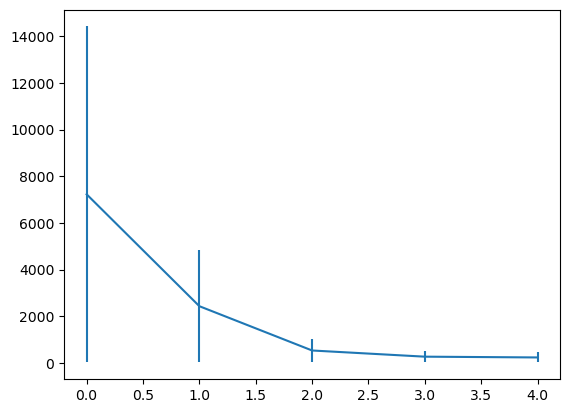

In [12]:
from skbio import DistanceMatrix, OrdinationResults

ord_ = OrdinationResults.read('../results/joint-rpca-ord.txt')
dist_ = DistanceMatrix.read('../results/joint-rpca-dist.txt')
cv_plt = pd.read_csv('../results/joint-rpca-cv.txt', index_col=0)
ordination_samples = pd.concat([ord_.samples, metadata_shared], axis=1, sort=False)
plt.errorbar(cv_plt.index, cv_plt.mean_CV, yerr=cv_plt.std_CV/2)
plt.show()

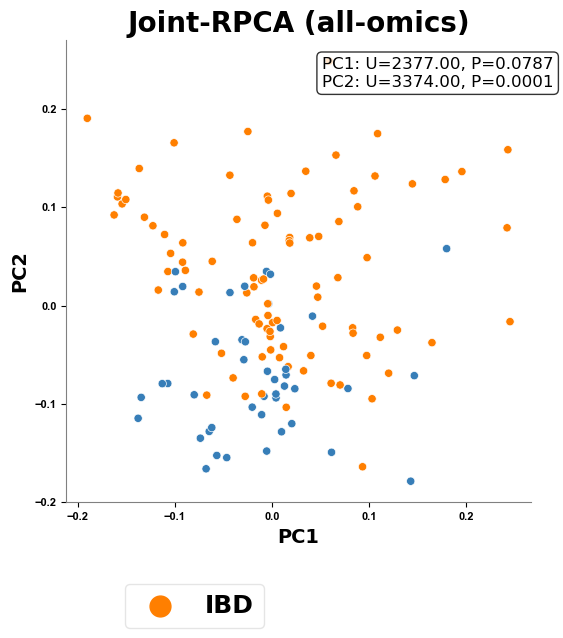

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

pal_ =  {'IBD':'#ff7f00', 'nonIBD':'#377eb8'}

ordindation_samples_plt = ordination_samples.copy().rename({0:'PC1', 1:'PC2', 2:'PC3'}, axis=1)

sns.scatterplot(x='PC1', y='PC2', hue='diagnosis_binned',
                data=ordindation_samples_plt, ax=ax, palette=pal_)

"""props = dict(boxstyle='round', facecolor='white', alpha=1)
f_, p_ = mannwhitneyu(ordindation_samples[ordindation_samples.diagnosis_binned == 'IBD'][1].values, 
                      ordindation_samples[ordindation_samples.diagnosis_binned != 'IBD'][1].values)
if p_ < 0.0001:
    p_ = 0.0001
txt_ = 'U=%.2f, P=%.4f' % (f_, p_)
ax.text(0.1, 0.1, txt_, fontsize=12, color='black', transform=ax.transAxes, bbox=props)
"""
txt_s = []
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
#ord_plt = ords_all[('HMP2_metabolomics', 'RPCA')]
for pc_ in ['PC1','PC2']:
    f_, p_ = mannwhitneyu(ordindation_samples_plt[ordindation_samples_plt.diagnosis_binned == 'IBD'][pc_].values,
                          ordindation_samples_plt[ordindation_samples_plt.diagnosis_binned != 'IBD'][pc_].values)
    #f_, p_ = perm_all[(title_[1], title_[0])][0], perm_all[(title_[1], title_[0])][1]
    if p_ < 0.0001:
        p_ = 0.0001
    txt_s.append('%s: U=%.2f, P=%.4f' % (pc_, f_, p_))
ax.text(0.55, 0.9, '\n'.join(txt_s), fontsize=12, color='black', transform=ax.transAxes, bbox=props)

    
ax.set_xlabel('PC1',
              color='black',
              weight='bold',
              fontsize=14)
ax.set_ylabel('PC2',
              color='black',
              weight='bold',
              fontsize=14)
ax.set_title('Joint-RPCA (all-omics)',
              color='black',
              weight='bold',
              fontsize=20)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(8)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(8)
    
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:], loc=2, 
                         bbox_to_anchor=(.10, -.15),
                         prop={'size':18, 'weight':'bold'},
                         #title="method:",
                         fancybox=True, framealpha=.5,
                         ncol=2, markerscale=2.5)
legend.get_title().set_fontsize('14')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
    
#ax.set_xlim(-.2, .3)
#ax.set_ylim(-.3, .2)

# """plt.savefig('../../../results/case-studies/ihmp/shared_metagenomics/ord-plot.pdf',
#             dpi=1000, 
#             bbox_inches='tight',
#             facecolor=fig.get_facecolor(), 
#             edgecolor='none')"""

plt.show()